In [1]:
%reload_ext autoreload
%autoreload 2
import time
import torch
import skimage
import matplotlib.pyplot as plt
import numpy as np
import importlib

from torch.utils.data import DataLoader

from networks.image_fitting import ImageFitting
import networks.trainable as trainable
from utils.utils import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
importlib.reload(trainable)


<module 'networks.trainable' from '/Users/patrickhaft/Informatik_Master/5_Semester/IDP/INR/networks/trainable.py'>

In [3]:
mps_device = torch.device("mps")

In [4]:
cameraman = ImageFitting(256, skimage.data.camera())
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_train_act = trainable.Trainable(in_features=2,  hidden_features=256, hidden_layers=3, out_features=1, vmin=-6, vmax=6, num_weights=31, init="linear")
img_train_act.to(mps_device)

/Users/patrickhaft/opt/anaconda3/envs/NIR/lib/python3.8/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1685171333734/work/aten/src/ATen/native/TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Trainable(
  (net): Sequential(
    (0): TrainableActLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
      (trainable_activation): TrainableActivation()
    )
    (1): TrainableActLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (trainable_activation): TrainableActivation()
    )
    (2): TrainableActLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (trainable_activation): TrainableActivation()
    )
    (3): TrainableActLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (trainable_activation): TrainableActivation()
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

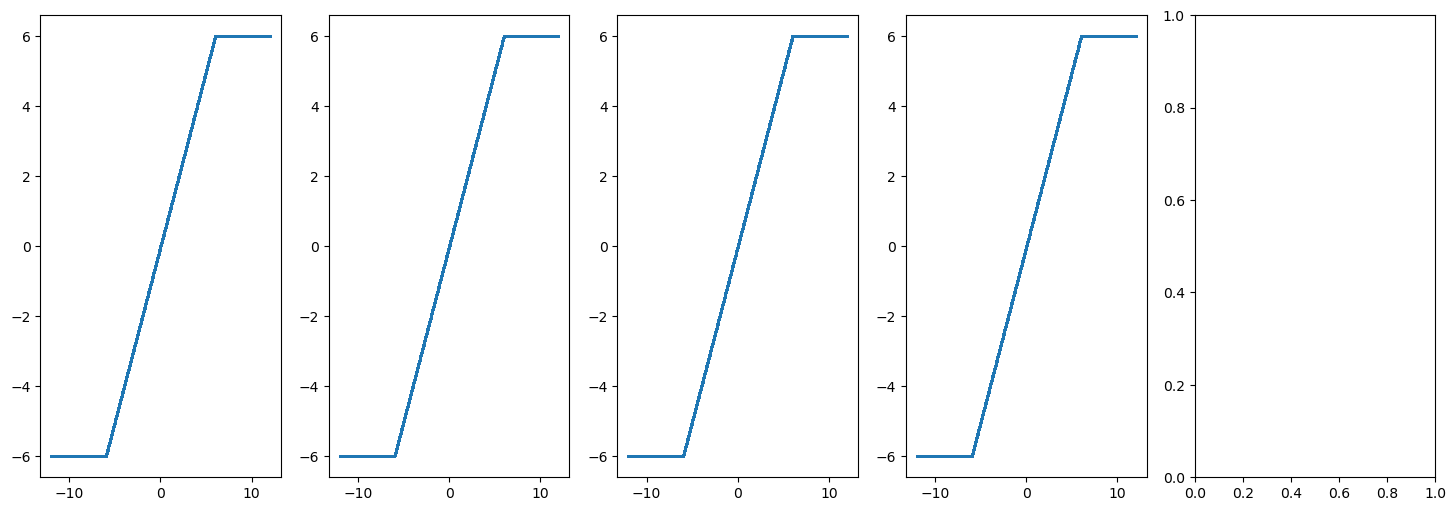

In [5]:
layer_draw = img_train_act.draw()
fig, axes = plt.subplots(1,5, figsize=(18,6))
for i in range(4):
    axes[i].scatter(layer_draw[i][0].cpu().detach().numpy(), layer_draw[i][1].cpu().detach().numpy(), s=5, marker=".")
plt.show()

Step 0, Total loss 0.307635


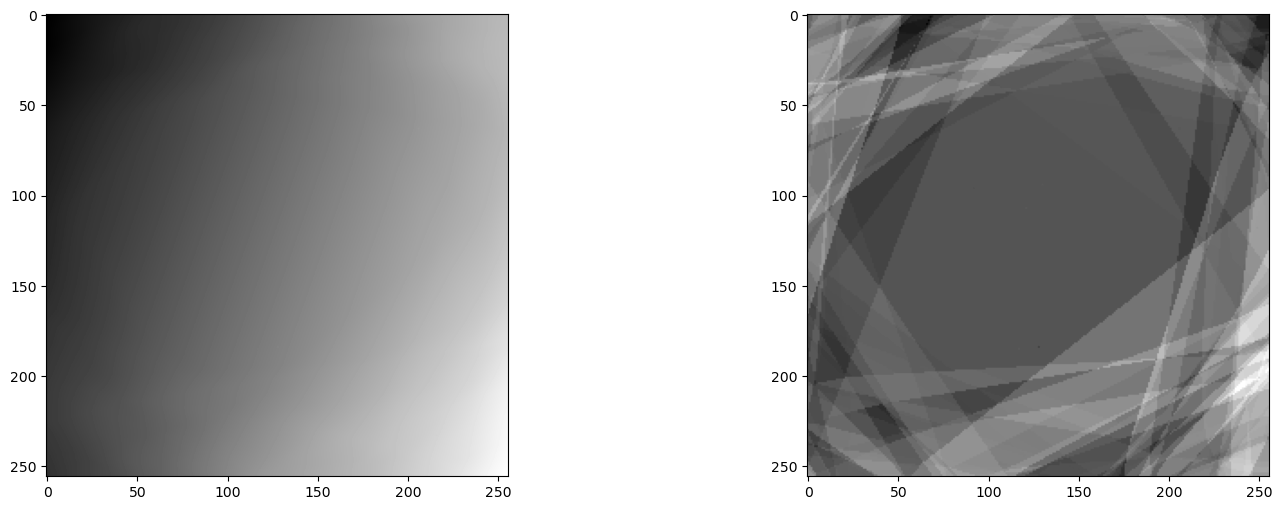

Step 1, Total loss 196.464020


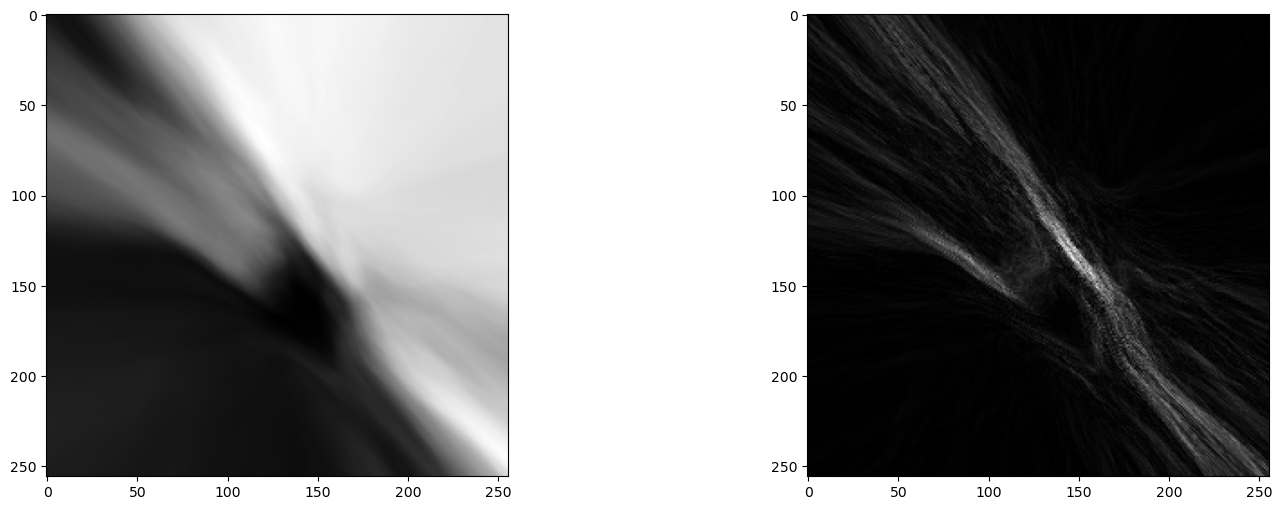

Step 2, Total loss 4304.844727


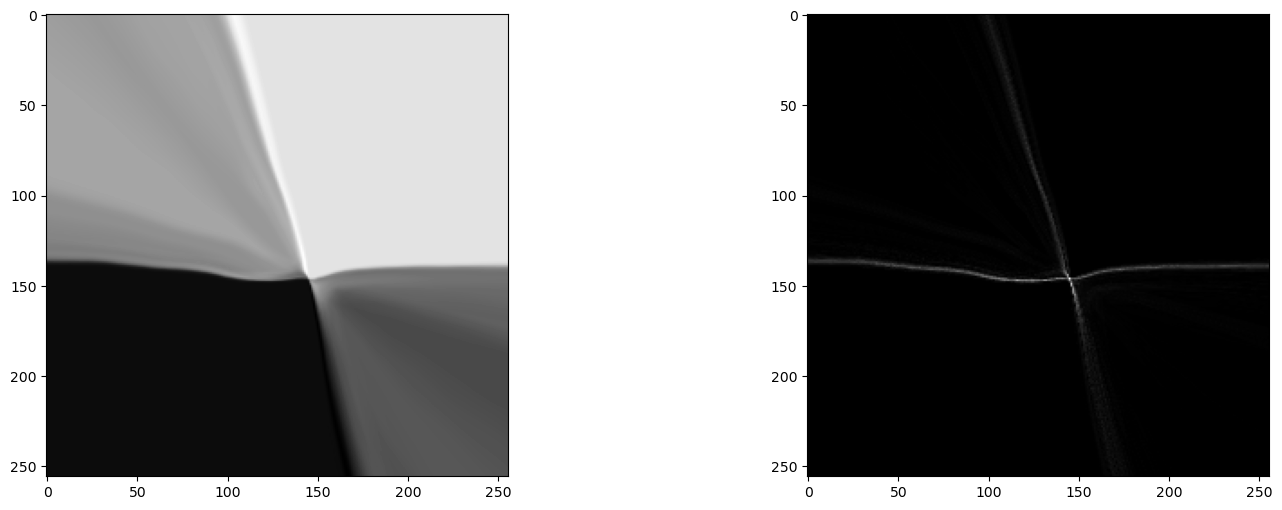

In [6]:
total_steps = 3 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 1

optim = torch.optim.Adam(lr=1e-1, params=img_train_act.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(mps_device), ground_truth.to(mps_device)

for step in range(total_steps):
    # print("Running the forward path")
    model_output, coords = img_train_act(model_input)
    # print("Calculationg the loss")
    # start_time = time.time()
    loss = ((model_output - ground_truth)**2).mean()
    # end_time = time.time()
    # elapsed_time = end_time - start_time
    # print("Step %d, Total loss %0.6f" % (step, loss))
    # print("Execution time:", elapsed_time, "seconds")    
    # layer_draw = img_train_act.draw()
    # fig, axes = plt.subplots(1,5, figsize=(18,6))
    # for i in range(5):
    #     axes[i].scatter(layer_draw[i][0].detach().numpy(), layer_draw[i][1].detach().numpy(), s=5, marker=".")
    # plt.show()
    # if not step % (steps_til_summary / 5):
    #     print("Step %d, Total loss %0.6f" % (step, loss))
        
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)


        fig, axes = plt.subplots(1,2, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(256,256).detach().numpy(), cmap='gray')
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy(), cmap='gray')
        # axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy(), cmap='gray')
        plt.show()
    
    # print("Setting gradient to zero")    
    # start_time = time.time()
    optim.zero_grad()
    # end_time = time.time()
    # elapsed_time = end_time - start_time
    # print("Execution time:", elapsed_time, "seconds")


    # print("Running the backward path")
    # start_time = time.time()
    loss.backward()
    # end_time = time.time()
    # elapsed_time = end_time - start_time
    # print("Execution time:", elapsed_time, "seconds")

    # print("Updating the models parameters")
    # start_time = time.time()
    optim.step()
    # end_time = time.time()
    # elapsed_time = end_time - start_time
    # print("Execution time:", elapsed_time, "seconds")
    

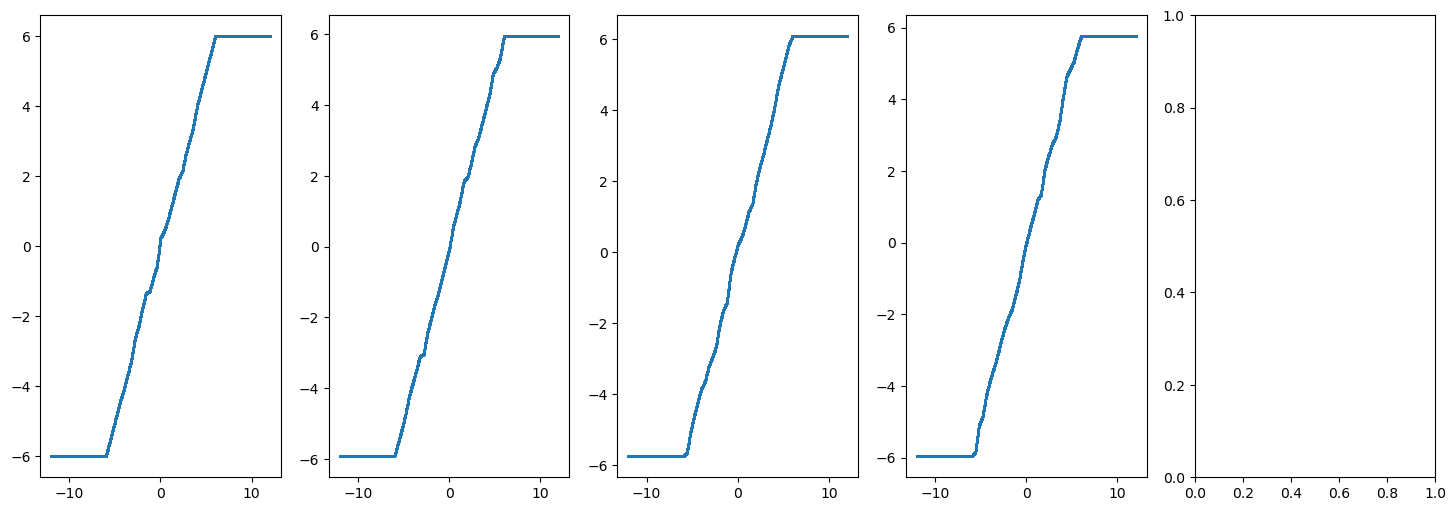

In [7]:
layer_draw = img_train_act.draw()
fig, axes = plt.subplots(1,5, figsize=(18,6))
for i in range(4):
    axes[i].scatter(layer_draw[i][0].cpu().detach().numpy(), layer_draw[i][1].cpu().detach().numpy(), s=5, marker=".")
plt.show()